In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm

import corner
import copy

import multiprocessing as mp

from tqdm import tqdm

from functools import partial

import matplotlib.lines as mlines

# Setup

In [2]:
from hmc import HMC
from distributions import UnivariateNormal, IndependentMultivariateNormal, MultivariateNormal

In [3]:
# class HMC():
#     """
#     Hamiltonian Monte Carlo sampler
#     https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html
#     """
    
#     def __init__(self, logp, dlogp, dt, L, M, n_args, prop='leapfrog'):
#         """
#         Arguments:
#             logp: 
#                 Function which accepts two inputs (args, data) and returns log
#                 probability of the objective model
                
#             dlogp:
#                 Function which which accepts two inputs (args, data) and returns the
#                 gradient of the log probability w.r.t. the parameters as a np array
                
#             dt: Time step
            
#             L: Number of leapfrog iterations to calculate
            
#             M: covariance of momentum sampling multivariate normal
            
#             n_args: number of parameters to sample
#         """
#         self.logp = logp
#         self.dlogp = dlogp
#         self.dt = dt
#         self.L = L
#         self.M = M
#         self.n_args = n_args
        
#         if prop=='leapfrog':
#             self.proposal = self.prop_lf
#         elif prop=='yoshida':
#             self.proposal = self.prop_yo
#         else:
#             raise
    
#     def U(self, x, data):
#         return -self.logp(x,data)
    
#     def dU(self, x, data):
#         return self.dlogp(x,data)
    
#     def K(self, v):
#         return -mvnorm.logpdf(v, mean=np.zeros(self.n_args), cov=self.M)
    
#     def prop_lf(self, x, v, data):
#         # Leapfrog
#         # https://en.wikiself.dlogp(x, data)pedia.org/wiki/Leapfrog_integration
#         x, v = copy.deepcopy((x,v))

#         for _ in range(self.L):
#             v += (self.dt/2)*self.dU(x, data)
#             x += self.dt*np.dot(np.linalg.inv(self.M), v)
#             v += (self.dt/2)*self.dU(x, data)
        
#         return x, v
    
#     def prop_yo(self, x, v, data):
#         # 4th order Yoshida integrator
#         # https://en.wikiself.dlogp(x, data)pedia.org/wiki/Leapfrog_integration
#         x, v = copy.deepcopy((x,v))
        
#         crt2 = (2.**(1./3))
#         w0 = -crt2/(2-crt2)
#         w1 = 1./(2-crt2)
#         c1=c4=w1/2
#         c2=c3=(w0+w1)/2
#         d1=d3=w1
#         d2=w0
#         for _ in range(self.L):
#             x += c1*np.dot(np.linalg.inv(self.M), v)*self.dt
#             v += d1*self.dU(x, data)*self.dt
#             x += c2*np.dot(np.linalg.inv(self.M), v)*self.dt
#             v += d2*self.dU(x, data)*self.dt
#             x += c3*np.dot(np.linalg.inv(self.M), v)*self.dt
#             v += d3*self.dU(x, data)*self.dt
#             x += c4*np.dot(np.linalg.inv(self.M), v)*self.dt

#         return x, v
    
    
#     def sample(self, N_samp, data, init_x=None, verbose=False):
#         """Samples one HMC chain for N_samp samples."""
        
#         if init_x is None:
#             x = 2*np.random.rand(self.n_args)-0.5
#         else:
#             x = init_x
            
#         xs = np.zeros(shape=(N_samp, self.n_args))
#         xs[0] = x
        
#         i_s = range(1,N_samp)
#         if verbose: # Print progress bar
#             i_s = tqdm(i_s)
        
#         for i in i_s:
#             v = mvnorm.rvs(mean=np.zeros(self.n_args), cov=self.M)
#             xnew, vnew = self.proposal(x, v, data)

#             alpha = np.exp(self.U(x, data) +  self.K(v)
#                            - self.U(xnew, data) - self.K(vnew))

#             if np.random.rand() <= min(1, alpha):
#                 xs[i] = xnew
#                 x = xnew
#             else:
#                 xs[i] = xs[i-1]
                
#         return xs
    
#     def _pool_helper(self, N_samp, data, init_x, verbose, seed):
#         np.random.seed(seed)
#         return self.sample(N_samp, data, init_x, verbose)
    
#     def sample_pool(self, N_samp, data, N_chains, init_x=None, verbose=False):
#         """Samples N_chains HMC chains in parallel, each for N_samp samples"""
        
#         f = partial(self._pool_helper, N_samp, data, init_x, verbose)
        
#         with mp.Pool(N_chains, initargs=(N_samp, data, init_x)) as pool:
#             out = np.array(pool.map(f, 
#                                     np.random.randint(0, 1e5, N_chains),
#                                     ))
            
#         return out

# Univariate Normal $\mathcal{N}(\mu,\sigma)$

In [4]:
# Generate observed data
truth = (0,1)

N = 10000
data = norm.rvs(loc=truth[0], scale=truth[1], size=N)

print(f'mu_hat: {np.mean(data)}, sig_hat: {np.std(data)}')

mu_hat: 0.004367872081953005, sig_hat: 1.0062346219306406


In [5]:
# Define Model

dist = UnivariateNormal()
n_args=2

In [6]:
# Leapfrog
N_chains = 5
slf = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(2), n_args=n_args, prop='leapfrog')
xslf = slf.sample_pool(int(1e4), data, N_chains, init_x=[0.1,0.5], verbose=True)

 12%|█▏        | 1216/9999 [00:02<00:17, 505.95it/s]Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/Users/glasschen/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/glasschen/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/glasschen/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/glasschen/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/glasschen/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/

KeyboardInterrupt: 

In [14]:
# Yoshida
N_chains = 5
syo = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(2), n_args=n_args, prop='yoshida')
xsyo = syo.sample_pool(int(1e4), data, N_chains, init_x=[0.1,0.5], verbose=True)

100%|██████████| 9999/9999 [00:45<00:00, 220.79it/s]

100%|██████████| 9999/9999 [00:45<00:00, 220.57it/s]


In [8]:
# Ruth
N_chains = 5
sru = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(2), n_args=n_args, prop='ruth')
xsru = sru.sample_pool(int(1e4), data, N_chains, init_x=[0.1,0.5], verbose=True)

100%|██████████| 9999/9999 [00:51<00:00, 196.01it/s]


In [14]:
# Burn
xslf = xslf[:,1000:,:]
xsyo = xsyo[:,1000:,:]
xsru = xsru[:,1000:,:]

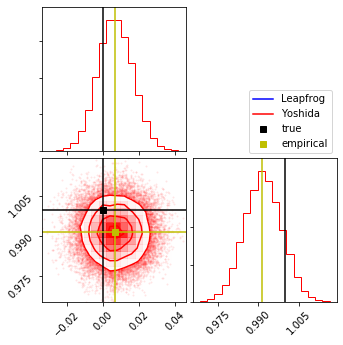

In [15]:
# Corner plot
f = corner.corner(xslf.reshape(-1,2), labels=['$\mu$', '$\sigma$'],
                  color='b')
corner.corner(xsyo.reshape(-1,2), fig=f,
              color='r')
corner.corner(xsru.reshape(-1,2), fig=f,
              color='r')

axes = np.array(f.axes).reshape((n_args, n_args))

hat = (np.mean(data), np.std(data))
for i in range(n_args):
    ax = axes[i, i]
    ax.axvline(truth[i], color="k")
    ax.axvline(hat[i], color="y")
for yi in range(n_args):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(truth[xi], color="k")
        ax.axvline(hat[xi], color="y")
        ax.axhline(truth[yi], color="k")
        ax.axhline(hat[yi], color="y")
        c = ax.plot(truth[xi], truth[yi], "sk", label='true')[0]
        d = ax.plot(hat[xi], hat[yi], "sy", label='empirical')[0]

b = mlines.Line2D([], [], color='blue', label='Leapfrog')
r = mlines.Line2D([], [], color='red', label='Yoshida')

plt.legend(handles=[b,r,c,d], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig('uni_corner.pdf')

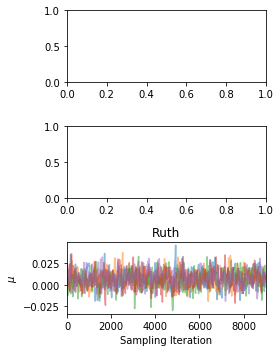

In [18]:
# Trace
r=20

f, axs = plt.subplots(3, 1, figsize=(4, 5))

for i in range(N_chains):
    axs[0].plot(range(0,xslf.shape[1],r), xslf[i,::r,0], alpha=0.5)
axs[0].set_ylabel(f'$\mu$')
axs[0].set_xlim(0,xslf.shape[1])
# axs[0].set_ylim(-0.05,0.05)
axs[0].set_title('Leapfrog')
axs[0].tick_params(axis="x",direction="in", labelbottom=False)  

for i in range(N_chains):
    axs[1].plot(range(0,xsyo.shape[1],r), xsyo[i,::r,0], alpha=0.5)
axs[1].set_ylabel(f'$\mu$')
axs[1].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[1].set_title('Yoshida')
axs[1].tick_params(axis="x",direction="in", labelbottom=False)  

for i in range(N_chains):
    axs[2].plot(range(0,xsru.shape[1],r), xsru[i,::r,0], alpha=0.5)
axs[2].set_ylabel(f'$\mu$')
axs[2].set_xlim(0,xsru.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[2].set_title('Ruth')
axs[2].set_xlabel('Sampling Iteration')

plt.tight_layout()
f.savefig('uni_trace.pdf')

# Independent Multivariate Normal

In [3]:
# Generate observed data
ndims = 5 # Number of dimensions for multivariate Gaussian

mu_tru = 10*np.random.rand(ndims)
sig_tru = 5*np.random.rand(ndims)

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.cov(data)}')

mu_*: [5.59107527 8.42039689 3.06002467 9.40459875 8.09058053], sig_*: [[4.63706502 0.         0.         0.         0.        ]
 [0.         4.8817313  0.         0.         0.        ]
 [0.         0.         2.24488449 0.         0.        ]
 [0.         0.         0.         2.26375926 0.        ]
 [0.         0.         0.         0.         3.2329265 ]]
mu_hat: 6.915479763730584, sig_hat: [[11.60837758 12.57429449  3.66161719 ...  7.07159653  1.6462798
   8.23952706]
 [12.57429449 15.51890027  7.65881659 ...  7.67615261  3.33710879
   8.79520774]
 [ 3.66161719  7.65881659  8.82061364 ...  2.51788448  4.64975295
   2.38338702]
 ...
 [ 7.07159653  7.67615261  2.51788448 ...  5.17905309  2.85405887
   3.92512102]
 [ 1.6462798   3.33710879  4.64975295 ...  2.85405887  6.17456445
  -0.74555607]
 [ 8.23952706  8.79520774  2.38338702 ...  3.92512102 -0.74555607
   7.54376428]]


In [4]:
# Define Model

n_args = 2*ndims 
dist = IndependentMultivariateNormal(ndims)

In [5]:
N_chains = 7
slf = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(2*ndims), 
          n_args=2*ndims, prop='leapfrog')
xslf = slf.sample_pool(int(1e4), data, N_chains, 
                       init_x = np.concatenate([mu_tru, sig_tru]), 
                       verbose=True)

100%|██████████| 9999/9999 [03:06<00:00, 53.54it/s]

100%|██████████| 9999/9999 [03:07<00:00, 53.45it/s]


In [7]:
N_chains = 7
syo = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(2*ndims), n_args=2*ndims, prop='yoshida')
xsyo = syo.sample_pool(int(1e4), data, N_chains, 
                       init_x = np.concatenate([mu_tru, sig_tru]), 
                       verbose=True)


100%|██████████| 9999/9999 [06:14<00:00, 26.73it/s]


In [9]:
N_chains = 7
sruth = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(2*ndims), n_args=2*ndims, prop='ruth')
xsruth = sruth.sample_pool(int(1e4), data, N_chains, 
                       init_x = np.concatenate([mu_tru, sig_tru]), 
                       verbose=True)


100%|██████████| 9999/9999 [11:43<00:00, 14.22it/s]


In [14]:
N_chains = 7
scal = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(2*ndims), n_args=2*ndims, prop='calvo')
xscal = scal.sample_pool(int(1e4), data, N_chains, 
                       init_x = np.concatenate([mu_tru, sig_tru]), 
                       verbose=True)


100%|██████████| 9999/9999 [09:47<00:00, 17.03it/s]


In [15]:
# Burn
xslf = xslf[:,1000:,:]
xsyo = xsyo[:,1000:,:]
xsruth = xsruth[:,1000:,:]
xscal = xscal[:,1000:,:]

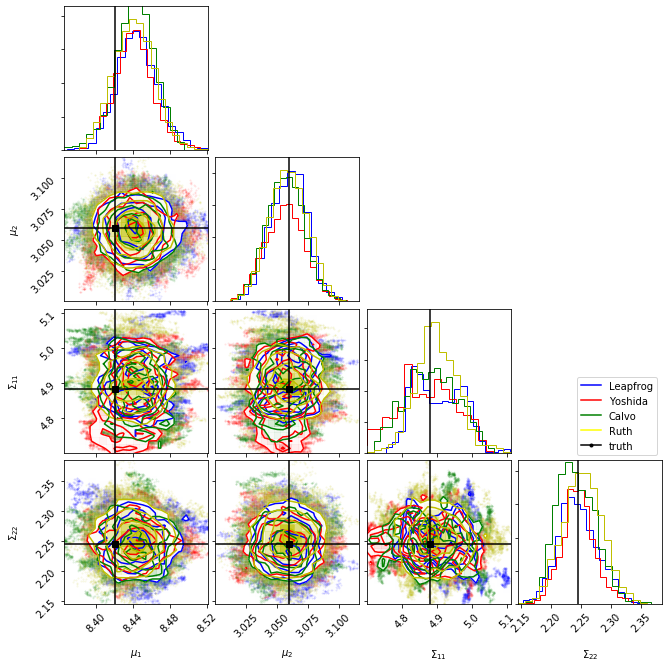

In [20]:
# Corner plot
sel = [1,2,6,7]

f = corner.corner(xslf.reshape(-1,n_args)[:,sel], 
                  labels=np.array([f'$\mu_{{{i}}}$' for i in range(ndims)] + [f'$\Sigma_{{{i}{i}}}$' for i in range(ndims)])[sel],
                  truths=np.concatenate([mu_tru, sig_tru])[sel],
                  color='b', truth_color='k')
corner.corner(xsyo.reshape(-1,n_args)[:,sel], fig=f,
              color='r')
corner.corner(xscal.reshape(-1,n_args)[:,sel], fig=f,
              color='g')
corner.corner(xsruth.reshape(-1,n_args)[:,sel], fig=f,
              color='y')

b = mlines.Line2D([], [], color='blue', label='Leapfrog')
r = mlines.Line2D([], [], color='red', label='Yoshida')
g = mlines.Line2D([], [], color='green', label='Calvo')
y = mlines.Line2D([], [], color='yellow', label='Ruth')
t = mlines.Line2D([], [], marker='.',color='k', label='truth')

plt.legend(handles=[b,r,g,y,t], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig('ind_corner.png')

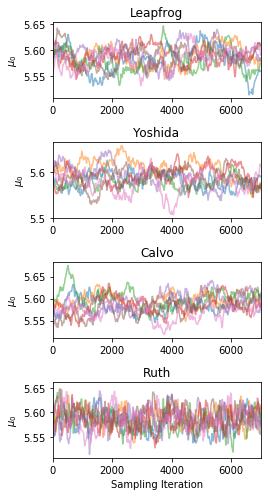

In [26]:
# Trace
r=20

f, axs = plt.subplots(4, 1, figsize=(4, 7))

for i in range(N_chains):
    axs[0].plot(range(0,xslf.shape[1],r), xslf[i,::r,0], alpha=0.5)
axs[0].set_ylabel(f'$\mu_0$')
axs[0].set_xlim(0,xslf.shape[1])
# axs[0].set_ylim(-0.05,0.05)
axs[0].set_title('Leapfrog')
# axs[0].tick_params(axis="x",direction="in", labelbottom=False)  

for i in range(N_chains):
    axs[1].plot(range(0,xsyo.shape[1],r), xsyo[i,::r,0], alpha=0.5)
axs[1].set_ylabel(f'$\mu_0$')
axs[1].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[1].set_title('Yoshida')
# axs[0].tick_params(axis="x",direction="in", labelbottom=False)


for i in range(N_chains):
    axs[2].plot(range(0,xscal.shape[1],r), xscal[i,::r,0], alpha=0.5)
axs[2].set_ylabel(f'$\mu_0$')
axs[2].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[2].set_title('Calvo')
# axs[2].set_xlabel('Sampling Iteration')

for i in range(N_chains):
    axs[3].plot(range(0,xsruth.shape[1],r), xsruth[i,::r,0], alpha=0.5)
axs[3].set_ylabel(f'$\mu_0$')
axs[3].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[3].set_title('Ruth')
axs[3].set_xlabel('Sampling Iteration')

plt.tight_layout()
f.savefig('ind_trace.png')

# Multivariate Normal $\mathcal{N}(0,\Sigma^{-1})$ + LF

In [3]:
def mat_to_LT(X):
    y = np.tril(Th_tru).flatten()
    return y[y!=0]

def LT_to_mat(y):
    X = np.zeros((ndims, ndims))
    X[np.tril_indices(ndims)] = y
    X+= X.T - np.diag(np.diagonal(X))
    return X

In [4]:
# Generate observed data
ndims = 3 # Number of dimensions for multivariate Gaussian
n_args = int((ndims-1)*ndims/2 + ndims)

mu_tru = np.zeros(ndims)
Th_tru = 3*np.random.rand(ndims, ndims) # Precision Matrix
Th_tru = np.dot(Th_tru, Th_tru.T)/2 # Symmetric, PSD

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.linalg.inv(Th_tru), size=N)

print(f'mu_*: {mu_tru}, Theta_*: {Th_tru}')
# print(f'mu_hat: {np.mean(data)}, sig_hat: {np.linalg.inv(np.cov(data))}')

mu_*: [0. 0. 0.], Theta_*: [[3.80778814 4.55439372 2.47914266]
 [4.55439372 5.7378231  3.61023905]
 [2.47914266 3.61023905 4.17813601]]


In [5]:
# Define Model 
dist = MultivariateNormal(ndims)


In [6]:
N_chains = 5
slf = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(n_args), 
          n_args=n_args, prop='leapfrog')
xslf = slf.sample_pool(int(1e4), data, N_chains, 
                       init_x = mat_to_LT(Th_tru), 
                       verbose=True)

100%|██████████| 9999/9999 [00:30<00:00, 331.17it/s]

100%|██████████| 9999/9999 [00:30<00:00, 331.17it/s]


In [7]:
N_chains = 5
syo = HMC(dist.logp, dist.dlogp, dt=1e-4, L=5, M=0.1*np.identity(n_args), 
          n_args=n_args, prop='yoshida')
xsyo = syo.sample_pool(int(1e4), data, N_chains, 
                       init_x = mat_to_LT(Th_tru), 
                       verbose=True)


100%|██████████| 9999/9999 [01:18<00:00, 126.91it/s]


In [35]:
# Burn
xslf = xslf[:,1000:,:]
xsyo = xsyo[:,1000:,:]

In [8]:
# Corner plot
labels = np.array([[f'$\Theta_{{{i}{j}}}$' for j in range(ndims)] for i in range(ndims)])
labels = np.tril(labels).flatten()
labels = labels[labels!='']

f = corner.corner(xslf.reshape(-1,n_args), 
                  labels=labels,
                  truths=mat_to_LT(Th_tru), 
                  color='b', truth_color='k')
corner.corner(xsyo.reshape(-1,n_args), fig=f,
              color='r')

b = mlines.Line2D([], [], color='blue', label='Leapfrog')
r = mlines.Line2D([], [], color='red', label='Yoshida')
t = mlines.Line2D([], [], marker='.', color='k', label='truth')

plt.legend(handles=[b,r,t], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig('pre_corner.pdf')

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4, 5 have no dynamic range. Please provide a `range` argument.

In [ ]:
# Trace
r=20

f, axs = plt.subplots(2, 1, figsize=(4, 3))

for i in range(N_chains):
    axs[0].plot(range(0,xslf.shape[1],r), xslf[i,::r,0], alpha=0.5)
axs[0].set_ylabel('$\Theta_{00}$')
axs[0].set_xlim(0,xslf.shape[1])
# axs[0].set_ylim(-0.05,0.05)
axs[0].set_title('Leapfrog')
axs[0].tick_params(axis="x",direction="in", labelbottom=False)  

for i in range(N_chains):
    axs[1].plot(range(0,xsyo.shape[1],r), xsyo[i,::r,0], alpha=0.5)
axs[1].set_ylabel('$\Theta_{00}$')
axs[1].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[1].set_title('Yoshida')
axs[1].set_xlabel('Sampling Iteration')

plt.tight_layout()
f.savefig('pre_trace.pdf')

# Evaluation

In [ ]:
import time
import matplotlib.pyplot as plt

In [ ]:
"""
Setup an experiment for one time. 
"""
def time_acc_per_experiment(steps, sampler, data, init_x):
    time0 = time.time()
    xs, acc = sampler.sample_with_acc(steps, data, init_x)
    time_cost = time.time() - time0
    return xs, time_cost, acc

"""
Setup experiments with different steps. 
"""
def time_acc_experiments(step_range, sampler, data, init_x):
    times = []
    accs = []
    xss = []
    for step in step_range:
        xs, time_cost, acc = time_acc_per_experiment(step, sampler, data, init_x)
        times.append(time_cost)
        accs.append(acc)
        xss.append(xs)
    return xss, times, accs


"""
Setup experiments with different steps for different samplers.
"""
def time_acc_with_different_samplers(step_range, sampler_dict, data, init_x):
    results = {}
    for k, sampler in sampler_dict.items():
        results[k] = {}
        xss, times, accs = time_acc_experiments(step_range, sampler, data, init_x)
        results[k]['xs'] = xss
        results[k]['time'] = times
        results[k]['acc'] = accs
    return results

# scripts for plotting computational cost vs.  acceptance ratio trade-offs
def plot_trade_offs(results, step_range):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title('Time vs. Steps on Different Samplers')
    ax1.set_xlabel('Sample steps')
    ax1.set_ylabel('Compute time(s)')
    for k, r in results.items():
        ax1.plot(step_range, r['time'], '-*', label=k)
    ax1.legend()
    ax1.set_xticks(step_range)

    ax2.set_title('Acceptance Rate vs. Steps on Different Samplers')
    ax2.set_xlabel('Sample steps')
    ax2.set_ylabel('Acceptance rate')
    for k, r in results.items():
        ax2.plot(step_range, r['acc'], '-*', label=k, )
    ax2.legend()
    ax2.set_xticks(step_range)

In [ ]:
step_range = range(1000, 2001, 500)
samplers = {
    'leap_frog': HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2), n_args=2),
    'dummy': HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2), n_args=2)
    }
results = time_acc_with_different_samplers(step_range, samplers, data, [0.1,0.5])

In [ ]:
plot_trade_offs(results, step_range)

In [28]:
# Get samples with step 2000
samples = np.array([r['xs'][-1] for _, r in results.items()])

In [62]:
# Get sequence with "leapforg" sampler
x = samples[0]

In [66]:
def effective_sample_size(x, functruncation=True, threshold=0.05):
    # A mapping from sample space to $R$
    # we use mean here
    M = len(x)
    if len(x.shape) > 1:
        f = x.mean(axis=-1)
    else:
        f = x
    
    # Compute mu, sigma
    mu_f = f.mean()
    var_f = f.var()
        
    ess = 0
    ro = np.zeros(M-1)
    temp = f - mu_f
    for s in range(M-1):
        ro[s] = temp[s+1:].dot(temp[:M-s-1]) / (var_f * (M-s-1))
    if truncation:
        M_cutoff = np.argmax(ro < threshold)
        ess = M / (1 + 2 * (1 - np.arange(1, M_cutoff+1) / M).dot(ro[:M_cutoff]))
    else:
        ess = M / (1 + 2 * (1 - np.arange(1, M) / M).dot(ro))
    return ess

"""
Special note: in original "No U-Turn" paper, ESS was computed
in two ways: 1. map from $R^d$ to $R$ then compute the ESS;
2. directly compute ESS on seperate dimensions
"""
def effective_sample_size_on_seperate_dimensions(x, truncation=True, threshold=0.05):
    if len(x.shape) > 1:
        res = []
        for i in range(x.shape[-1]):
            res.append(effective_sample_size(x[:, i]))
        return res
    else:
        return effective_sample_size(x, truncation, threshold)

In [65]:
leap_frog_ess = effective_sample_size(x)
print(leap_frog_ess)

115.46017290998668


# Scratch

## Pymc comparison

In [12]:
# Define Model 
dist = MultivariateNormal(ndims)


In [13]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [20]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=ndims,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(ndims, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    mu = pm.Normal('mu', 0., 10., shape=ndims,
                  testval=data.mean(axis=0))
    obs = pm.MvNormal('data', mu, chol=L, observed=data)
    
    step = pm.NUTS()
    trace = pm.sample(draws=int(1e3), step=step, cores=4, progressbar=True, 
                      compute_convergence_checks=False)

/Users/maho/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/maho/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, packed_L]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [01:13<00:00, 81.90draws/s] 
The acceptance probability does not match the target. It is 0.880665

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24c6da10>,
      dtype=object)

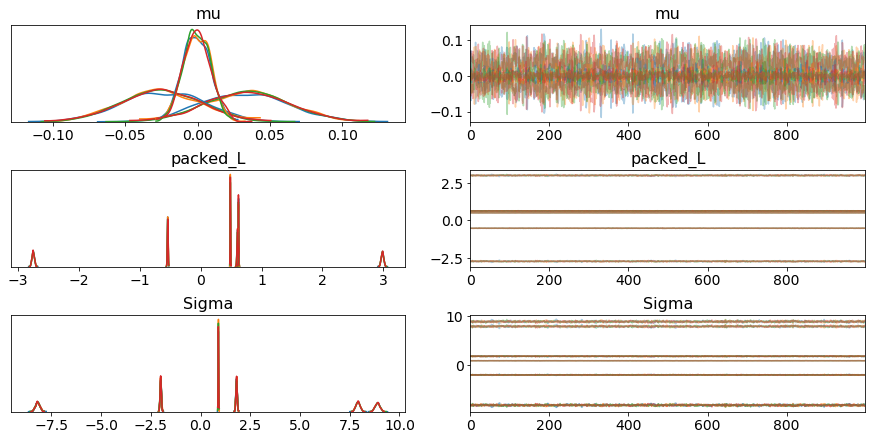

In [21]:
pm.traceplot(trace)